# In Plane Flash Method Data Reduction Using ODRPACK 
 (c) Jozef Gembarovic 2016

 ODRPACK (Orthogonal Distance Regression  PACKage) Version 2.1 - see [manual](https://docs.scipy.org/doc/external/odrpack_guide.pdf)

In [1]:
%pylab inline

import numpy as np # for Numerical Python
import scipy.special as scs # for Bessel functions 
from scipy.optimize import brenth # for finding zeroes of a function
import scipy.odr.odrpack as odrpack #  for ODRPACK
import os # for files manipulatios (operating system package)
from matplotlib import pyplot # for plots
from matplotlib import gridspec # for resizing figures

Populating the interactive namespace from numpy and matplotlib


### Define sample geometry parameters and their values (in CGS units) 

In [2]:
L = 0.0001  #  sample thickness L << R
R = 1.270 # sample radius
IRI = 0.89 # irradiated radius inner
IRO = 1.15 # irradiated radius outer
VRI = 0.0 # viewed radius inner
VRO = 0.381 # viewed radius outer

# dimensionless radii
VROD= VRO/R
IRID= IRI/R
IROD= IRO/R
    

### In-Plane Flash "Fin" Model (one dimensional heat flow, an instantaneous pulse, negligible through-thickness gradient)
Analytical formula for the temperature response at the rear side of a very thin sample to an instantaneous (doughnat shape) heat pulse at the front side for $t>0$ is

$$ T(t,a)=T_0+T_{max}\big[1+\frac{4R^4}{r_0^2(R_o^2-R_i^2)}\sum_{i=1}^\infty \Phi(\beta_i) \exp{\big(-\beta_i^2\frac{at}{R^2}}\big)\big]\exp{\big(-m^2 \frac{at}{R^2}\big)},$$

where $a$ is the thermal diffusivity in the sample in-plane (radial) direction, $T_0$ is the initial (baseline) temperature level, $T_{max}$ represents the maximum temperature rise of adiabatically insulated sample after the flash, $R$ is the sample radius, $R_i$ and $R_o$ are the heat pulse inner and outer radii, respectively, $r_o$ is the viewed area outer radius

$$\Phi(\beta_i)= \frac{r_0J_1\big(\beta_i\frac{r_o}{R}\big)\big[R_oJ_1\big(\beta_i\frac{R_o}{R}\big)-R_iJ_1\big(\beta_i\frac{R_i}{R}\big)}{R^2\beta_i^2J_0(\beta_i)^2}, $$

and $\beta_i$, $i=0,1,2,3,\dots$, are positive roots of 

$$ J_1(\beta)=0. $$

$J_0(x)$ and $J_1(x)$ are Bessel functions of the 1st kind. The heat pulse is coaxial to the sample main axis and the viewed area center is in the center of the rear face of the sample.

Heat losses from the sample surfaces are characterized by the dimensionless parameter $m$, which is proportional to the ratio of the heat transfer coefficient to the thermal conductivity of the sample. 

In [16]:
def rootsearch(f,a,b,dx):
    x1 = a; f1 = f(a)
    x2 = a + dx; f2 = f(x2)
    while f1*f2 > 0.0:
        if x1 >= b:
            return None,None
        x1 = x2; f1 = f2
        x2 = x1 + dx; f2 = f(x2)
    return x1,x2


def mroots(f, a, b, eps=1e-2):
    #print ('The roots on the interval [%f, %f] are:' % (a,b))
    i=0
    myroots=[]
    while 1:
        x1,x2 = rootsearch(f,a,b,eps)
        if x1 != None:
            a = x2
            #root = bisect(f,x1,x2,1)
            root = brenth(f,x1,x2, xtol=1e-16)
            if root != None:
                pass
       #     print ('root',i, root, f(root, Bio))
            myroots.append(root)
            i = i+1
        else:
            #print ('\nDone')
            return myroots
            
            break

# transcendental function for eigenvalues beta_i calculations
def funR(x): 
    return (scs.j1(x))

In [17]:
betas = mroots(funR, 0.00001, 200)

In [18]:
def flashIP(t, a, m, betas): # One dimensional model with heat losses
    g2 = list(np.array(betas)**2) 
    suma=0.0
    for i in range(0, len(betas)):
        Phi = VROD*scs.j1(betas[i]*VROD)*(IROD*scs.j1(betas[i]*IROD)-IRID*scs.j1(betas[i]*IRID))/(g2[i]*scs.j0(betas[i])**2)     
        suma = suma + Phi*np.exp(-betas[i]**2*a*t/R**2)  
    
    return (1+4/((IROD**2-IRID**2)*VROD**2)*suma)*np.exp(-m**2*a*t/R**2)

### Simulate 'experimental' data
using the Fin Model - calling the function "flashIP"

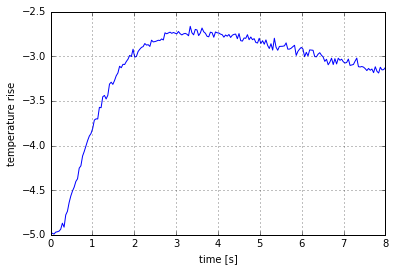

In [21]:
N=200 # number of experimental points
time = np.linspace(0.001,8.,N) # define time points
#temperature= flashIP(time, 0.1, 0.0001, betas)

noise = 0.01 # sigma (relative to Tmax) for noise level

# Theoretical values
# my theoretical values used for calculation of 'experimental' data, feel free to change them!
baseline_theor = -5.0
Tmax_theor = 3.0  # Tmax (adiabatic case)
td_theor = 0.1 # thermal diffusivity
m_theor  = 1.0 # Biot number

# define a new vector 
theors = [baseline_theor, Tmax_theor, td_theor, m_theor] 

betas = mroots(funR, 0.0001, 200)

# calculate temperature rise
temperature=baseline_theor+Tmax_theor*(flashIP(time, td_theor, m_theor, betas) # calculate the temperature in time
    + np.random.normal(0,noise,N)) # and add Gaussian noise with sigma = noise

# plot Experimental Data
pyplot.plot(time, temperature) 
pyplot.xlabel("time [s]")
pyplot.ylabel("temperature rise")
pyplot.grid()
pyplot.show()

## Use ODRPACK for Finding Optimal Set of Parameters

In [29]:
# first delete the file 'filename' if it already exist to make room for a new one, generated by the ODRPACK
filename="resultsodrIP.txt" 
## delete only if file exists ##
if os.path.exists(filename):
    os.remove(filename)
else:
    print("Sorry, I can not remove %s file." % filename)
    
# define analytical function for temperature distribution used by the fitting procedure
def fIP(B, x):
#    betas = mroots(funR, 0.0001, 200) # once calculated then always used  
    return B[0]+B[1]*flashIP(x, B[2], B[3], betas) 
    
flash = odrpack.Model(fIP) # our model will use 2D model with heat losses

N=N #  endpoit index. (N-jump+1) is the number of experimental points to be fitted
jump=0 # jump over the first x points after the flash beginning (distorted part)

time=time[jump:N]
temperature=temperature[jump:N]

mydata = odrpack.RealData(time, temperature, sx=0.00001, sy=0.0001) # use already simulated data. sx and sy are uncertainties for time and temperature points, resp.

myodr = odrpack.ODR(mydata, flash, beta0=[-5.0, 2.5, 0.01, 0.02],  # define ODRPACK input parameters - beta0 are initial guess values
                    iprint=6616, rptfile=filename, ifixb=[0,1,1,1] )             # for the baseline level, Beta[0], Tmax, Beta[1], 
                                                                # the thermal diffusivity, Beta[2], and the Biot number, Beta[3] 
                                                    
myoutput = myodr.run() # run Forrest (ODRPACK), run!!
myoutput.pprint() # print a standard simple output

# a more detail report from the ODRPACK is in a freshly created text file "resultsodrIP.txt"  

Beta: [-5.          2.97965296  0.10106796  0.98711288]
Beta Std Error: [ 0.          0.01766237  0.00071743  0.01122149]
Beta Covariance: [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   3.55865407e-09  -1.27884494e-10   2.22195041e-09]
 [  0.00000000e+00  -1.27884494e-10   5.87140214e-12  -8.37459605e-11]
 [  0.00000000e+00   2.22195041e-09  -8.37459605e-11   1.43644591e-09]]
Residual Variance: 87662.1525828
Inverse Condition #: 0.00213222605342
Reason(s) for Halting:
  Sum of squares convergence


In [30]:
B = myoutput.beta # final results of calculated optimal parameters
B-theors

array([ 0.        , -0.02034704,  0.00106796, -0.01288712])

## Reconstruct the Response Curve

Relative errors [baseline level, Tmax, thermal diffusivity, parameter m] in percent are: 
[-0.         -0.67823464  1.06796176 -1.28871198]

 
 Histogram of residuals


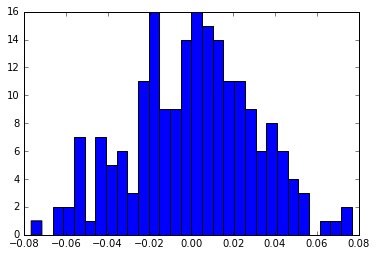

In [36]:
B = myoutput.beta # final results of calculated optimal parameters
betas = mroots(funR, 0.0001, 200) 

time = time[jump:N]
theoryIP  = B[0]+B[1]*flashIP(time, B[2], B[3], betas) 
theoryIP0 = B[0]+B[1]*flashIP(time, B[2], 0.0, betas) 

fig = pyplot.figure(figsize=(14, 18)) 

pyplot.figure(1)
pyplot.subplot(211)
pyplot.plot(time, temperature, 'b', label="experiment")
pyplot.plot(time, theoryIP,'r', label="Fin theory with heat losses")
pyplot.plot(time, theoryIP0,'g', label="Fin theory with zero heat losses")

pyplot.xlabel("time [s]")
pyplot.ylabel("temperature rise")
pyplot.legend(loc=4)
pyplot.grid()

residuals = temperature - theoryIP

pyplot.subplot(212)
pyplot.plot(time, residuals, 'g+', label="residuals")
pyplot.xlabel("time [s]")
pyplot.ylabel("residuals")
pyplot.grid()

pyplot.show()

pyplot.hist(residuals, 30) # plot histogram of residuals

# calculate relative errors
errors = (B-theors)/theors*100 
print 'Relative errors [baseline level, Tmax, thermal diffusivity, parameter m] in percent are: \n',errors
print "\n \n Histogram of residuals"

